# Virus Spread Model using AgentPy

An agent-based model that simulates the propagation of a disease thorugh a network.

In [1]:
# Import libraries.

# Model design.
import agentpy as ap
import networkx as nx
import random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython

## Defining the Model

We define a new agent type `Person` by creating a subclass of `Agent`. This new agent has two methods: `setup()` will be called automatically at the agent's creation and `being_sick()` will be called by the `Model.step()` function. Three tools are used within this class:

- `Agent.p` returns the parameters of the model.
- `Agent.neighbors()` resturns a list of the agents' peers in the network.
- `random.random()` returns a uniform random draw between 0 and 1.

In [2]:
class Person(ap.Agent):

    def setup(self):
        """ Initialize a new variable at agent creation. """

        # Susceptible = 0, Infected = 1, Recovered = 2.
        self.condition = 0

    def being_sick(self):
        """ Spread disease to peers in the network. """

        rng = self.model.random

        for n in self.network.neighbors(self):

            if n.condition == 0 and self.p.infection_chance > rng.random():
                
                # Infect susceptible peer.
                n.condition = 1

            if self.p.recovery_chance > rng.random():

                # Recover from infection.
                self.condition = 2

Next, we can define our model `VirusModel` by creating a subclass of `Model`. The four methods of this class will be called automatically at different steps of the simulation.

In [3]:
class VirusModel(ap.Model):

    def setup(self):
        """ Initialize the agents and network of the model. """

        # Prepare a small-world network.
        # Watts-Strogatz network graph.
        graph = nx.watts_strogatz_graph(
            self.p.population,
            self.p.number_of_neighbors,
            self.p.network_randomness
        )

        # Create agents.
        self.agents = ap.AgentList(self, self.p.population, Person)

        # Create network.
        self.network = self.agents.network = ap.Network(self, graph)

        # Add agents as nodes of the network.
        self.network.add_agents(self.agents, self.network.nodes)

        # Infect a random share of the population.
        infected_initial = int(self.p.initial_infection_share * self.p.population)
        self.agents.random(infected_initial).condition = 1

    def update(self):
        """ Record variables after setup and each step. """

        # Record share of agents with each condition.
        for i, c in enumerate(("S", "I", "R")):

            # Number of agents with each condition.
            n_agents = len(self.agents.select(self.agents.condition == i))

            # Record the percentange of the population with each condition.
            self[c] = n_agents / self.p.population
            self.record(c)

        # Stop the simulation if disease is gone.
        if self.I == 0:
            self.stop()

    def step(self):
        """ Define the models' events per simulation step. """

        # Call being_sick for infected agents.
        self.agents.select(self.agents.condition == 1).being_sick()

    def end(self):
        """ Record evaluation measures at the end of the simulation. """

        # Record final evaluation measures.
        self.report("Total share infected", self.I + self.R)
        self.report("Peak share infected", max(self.log["I"]))


## Running a Simulation

We define a dictionary of parameters to run our model. A new instance of the model is created, passing the parameters as an argument, and the method `Model.run()` is used to perform the simulation and return its output.

In [4]:
parameters = {
    "population": 1000,
    "infection_chance": 0.3,
    "recovery_chance": 0.1,
    "initial_infection_share": 0.1,
    "number_of_neighbors": 2,
    "network_randomness": 0.5
}

model = VirusModel(parameters)
results = model.run()

Completed: 50 steps
Run time: 0:00:00.050017
Simulation finished


## Analyzing Results

The simulation returns a DataDict of recorded data with dataframes.

In [5]:
results

DataDict {
'info': Dictionary with 9 keys
'parameters': 
    'constants': Dictionary with 6 keys
'variables': 
    'VirusModel': DataFrame with 3 variables and 51 rows
'reporters': DataFrame with 3 variables and 1 row
}

In [6]:
results.variables.VirusModel

,S,I,R
t,,,
0,0.900,0.100,0.000
1,0.833,0.147,0.020
2,0.780,0.175,0.045
3,0.739,0.187,0.074
4,0.692,0.188,0.120
5,0.659,0.183,0.158
6,0.640,0.165,0.195
7,0.616,0.153,0.231
8,0.603,0.141,0.256


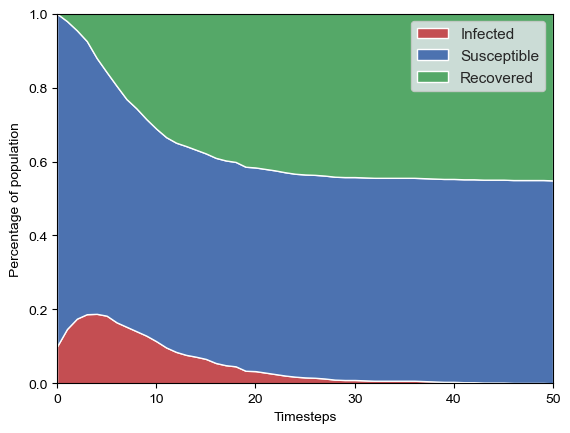

In [7]:
# Visualize the evolution of variables over time.
def virus_stackplot(data, ax):
    """ Stackplot of people's condition over time. """

    x = data.index.get_level_values("t")
    y = [data[var] for var in ["I", "S", "R"]]

    sns.set()
    ax.stackplot(
        x,
        y,
        labels = ["Infected", "Susceptible", "Recovered"],
        colors = ["r", "b", "g"]
    )
    ax.legend()
    ax.set_xlim(0, max(1, len(x) - 1))
    ax.set_ylim(0, 1)
    ax.set_xlabel("Timesteps")
    ax.set_ylabel("Percentage of population")

fig, ax = plt.subplots()
virus_stackplot(results.variables.VirusModel, ax)

## Creating an Animation

We can animate the model's dynamics using the function `animate_plot()`, which takes a model instance and displays the previous stackplot together with a network graph. The function `animate()` will call this plot function for every timestep and return an `matplotlib.animation.Animation`.

In [8]:
def animation_plot(m, axs):

    ax1, ax2 = axs
    ax1.set_title("Virus Spread")
    ax2.set_title("Share infected: {:%}".format(m.I))

    # Plot stackplot on first axis.
    virus_stackplot(m.output.variables.VirusModel, ax1)

    # Plot network graph on second axis.
    color_dict = {
        0: "b",
        1: "r",
        2: "g"
    }

    colors = [color_dict[c] for c in m.agents.condition]
    nx.draw_circular(
        m.network.graph,
        node_color = colors,
        node_size = 30,
        ax = ax2
    )

fig, axs = plt.subplots(1, 2, figsize = (8, 4))
parameters["population"] = 30
animation = ap.animate(VirusModel(parameters), fig, axs, animation_plot)

In [9]:
IPython.display.HTML(animation.to_jshtml())

## Multi-run Experiment

We can explore the effect of different parameter values using the classes `Sample`, `Range` and `IntRange` to create a sample of different parameter combinations. `saltelli` is an extension of the Sobol sequence, a popular quasi-random low-dsicrepancy sequence to generate uniform samples in parameter space as it reduces the error rates in the resulting sensitivity index calculations. 

In [10]:
# Parameters defined as ranges.
parameters = {
    "population": ap.IntRange(100, 1000),
    "infection_chance": ap.Range(0.1, 1.0),
    "recovery_chance": ap.Range(0.1, 1.0),
    "initial_infection_share": 0.1,
    "number_of_neighbors": 2,
    "network_randomness": ap.Range(0.0, 1.0)
}

# Create a sample object with all possible combination of parameters.
sample = ap.Sample(
    parameters,
    n = 128,
    method = "saltelli",
    calc_second_order = False
)

# Create an experiment that runs the model over all parameter combinations.
# Ten random iterations per combination.
experiment = ap.Experiment(VirusModel, sample, iterations = 10)
results = experiment.run()

Scheduled runs: 7680
Completed: 7680, estimated time remaining: 0:00:00
Experiment finished
Run time: 0:02:30.832783


In [31]:
# We are able to save results to file.
results.save()

Data saved to ap_output/VirusModel_1


In [32]:
# We can also load results from file.
results = ap.DataDict.load("VirusModel")

Loading from directory ap_output/VirusModel_1/
Loading info.json - Successful
Loading parameters_constants.json - Successful
Loading parameters_sample.csv - Successful
Loading parameters_log.json - Successful
Loading reporters.csv - Successful


In [33]:
# The measures in the data dict now hold one row per simulation.
results

DataDict {
'info': Dictionary with 12 keys
'parameters': 
    'constants': Dictionary with 2 keys
    'sample': DataFrame with 4 variables and 768 rows
    'log': Dictionary with 5 keys
'reporters': DataFrame with 3 variables and 7680 rows
}

array([[<Axes: title={'center': 'Total share infected'}>,
        <Axes: title={'center': 'Peak share infected'}>]], dtype=object)

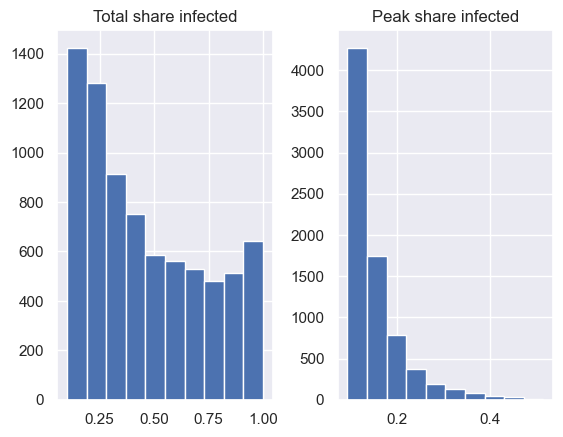

In [34]:
# We can get some summary stats.
results.reporters.hist()

## Sensitivity Analysis

The function `DataDict.calc_sobol()` calculates Sobol sensitivity indices for the passed results and parameter ranges, using the `SAlib` package. Sobol is a variance-based sensitivity analysis, a form of global sensitivity analysis. It decomposes the variance of the output of the model into fractions which can be attributed to inputs. Variance-based measures of sensitivity are attractive because they measure sensitivity across the whole input space, they can deal with nonlinear responses and they can measure the effect of interactions in non-additive models. The greater the sensitivity indices are, the more critical parameters are for the model. The indices are divided in First Order and Total Order.

### First Order Indices:

- First Order indices measure the contribution of individual factors to the variance in the model output independently of any interactions with other factors.
- They quantify the portion of the total output variance that can be attributed solely to each factor.
- First Order indices provide insights into the direct impact of a factor on the output, irrespective of any interactions or combined effects with other factors.
- They are calculated by analyzing the model output variations due to changes in each factor individually while keeping other factors fixed or averaged.

### Total Order Indices:

- Total Order indices measure the total contribution of each factor to the output variance, including both its individual effects and any interactions with other factors.
- They capture the combined effects of a factor as well as its interactions with all other factors in the model.
- Total Order indices provide a more comprehensive measure of the factor's influence on the output by accounting for its direct impact as well as any indirect effects resulting from interactions.
- They are calculated by considering the variations in the output due to changes in the factor alone, as well as variations resulting from interactions with other factors.

In [35]:
# Run Sobol sensitivity analysis for the obtained results.
# This add a new "sensitivity" category to the DataDict.
results.calc_sobol()

c:\Users\jperezv\AppData\Local\miniforge3\envs\multisim\Lib\site-packages\agentpy\datadict.py:148: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  reporters_df = self.reporters.groupby('sample_id').mean()


DataDict {
'info': Dictionary with 12 keys
'parameters': 
    'constants': Dictionary with 2 keys
    'sample': DataFrame with 4 variables and 768 rows
    'log': Dictionary with 5 keys
'reporters': DataFrame with 3 variables and 7680 rows
'sensitivity': 
    'sobol': DataFrame with 2 variables and 8 rows
    'sobol_conf': DataFrame with 2 variables and 8 rows
}

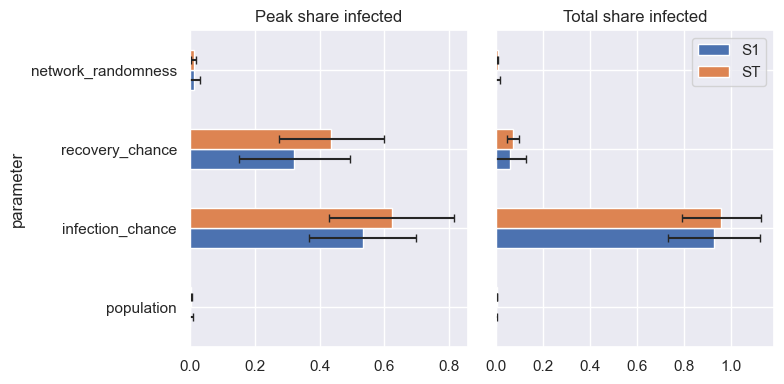

In [37]:
# Use Pandas to create a bar plot for the sensitivity indices.
def plot_sobol(results):
    """ Bar plot of Sobol sensitivity indices. """

    sns.set()
    fig, axs = plt.subplots(1, 2, figsize = (8, 4))
    si_list = results.sensitivity.sobol.groupby(by = "reporter")
    si_conf_list = results.sensitivity.sobol_conf.groupby("reporter")

    for (key, si), (_, err), ax in zip(si_list, si_conf_list, axs):

        si = si.droplevel("reporter")
        err = err.droplevel("reporter")
        si.plot.barh(xerr = err, title = key, ax = ax, capsize = 3)
        ax.set_xlim(0)

    axs[0].get_legend().remove()
    axs[1].set(ylabel = None, yticklabels = [])
    axs[1].tick_params(left = False)
    plt.tight_layout()

plot_sobol(results)

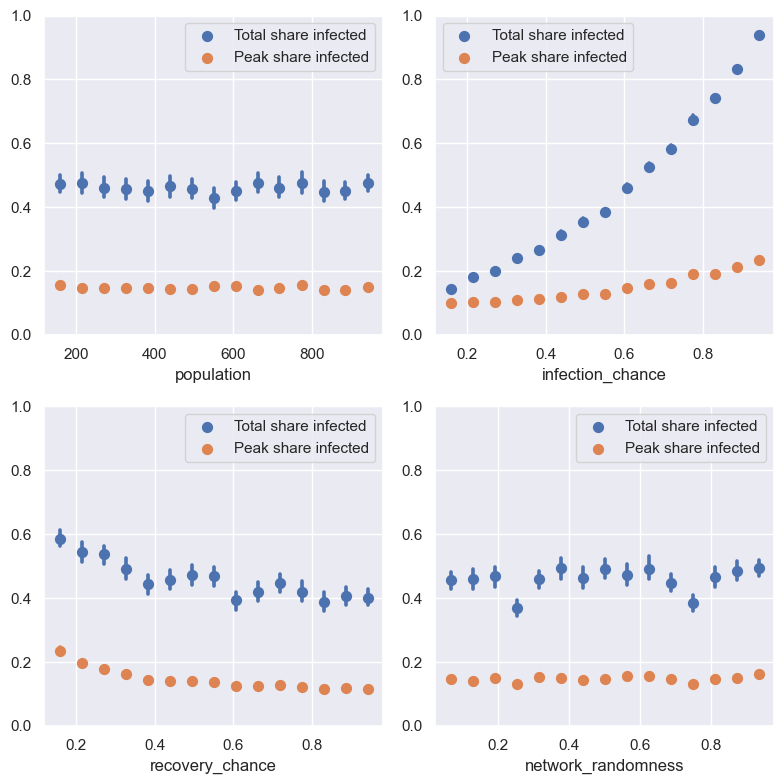

In [44]:
# Average evaluation measures over parameter variations.
def plot_sensitivity(results):
    """ Show average simulation results for different parameter values. """

    sns.set()
    fig, axs = plt.subplots(2, 2, figsize = (8, 8))
    axs = [i for j in axs for i in j] # Flatten list.

    data = results.arrange_reporters().astype("float")
    params = results.parameters.sample.keys()

    for x, ax in zip(params, axs):

        for y in results.reporters.columns[1:]:
            
            sns.regplot(
                x = x,
                y = y,
                data = data, 
                ax = ax,
                ci = 99,
                x_bins = 15,
                fit_reg = False,
                label = y
            )

            ax.set_ylim(0, 1)
            ax.set_ylabel("")
            ax.legend()
    
    plt.tight_layout()

plot_sensitivity(results)